In [1]:
# using Google CoLab as my coding environment 
# checking the GPU 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# data normalization
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y


# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

print("The shape of x_train", x_train.shape)
print("The shape of y_train", y_train.shape)
print("The shape of x_test", x_test.shape)
print("The shape of y_test", y_test.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step
The shape of x_train (50000, 3072)
The shape of y_train (50000, 10)
The shape of x_test (10000, 3072)
The shape of y_test (10000, 10)


In [0]:
# hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 1024
DROPOUT = 0.1
MOMENTUM = 0.95

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling2D, MaxPool2D, BatchNormalization,AveragePooling2D, Dropout

# construction a model with dropout layer
def build_mlp(input_shape, output_units=10,DROPOUT=0.1):
    input_layer = keras.layers.Input(input_shape)
    model = Sequential()
    
    # layer 1
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))
    
    # layer 2
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))
    
    # layer 3
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))
    
    # layer 4
    model.add(Dense(10))
    model.add(Activation('softmax'))

    return model

In [0]:
# import Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        for i in range(len(y_pred)):
          if y_true[i] == 1:
            if y_pred[i] == 1:
              tp += 1
            else:
              tn +=1
          else:
            if y_pred[i] == 1:
              fp += 1
            else:
              fn += 1
            
        
        logs["val_tp"] = tp
        logs["val_tn"] = tn
        
rec_tptn = Record_tp_tn()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
# model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# 在訓練後，將 f1sc 紀錄調出
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 58us/step - loss: 2.3123 - acc: 0.2014 - val_loss: 2.0932 - val_acc: 0.2731
Epoch 2/100
50000/50000 [==============================] - 2s 37us/step - loss: 1.9197 - acc: 0.3244 - val_loss: 1.8251 - val_acc: 0.3543
Epoch 3/100
50000/50000 [==============================] - 2s 38us/step - loss: 1.8037 - acc: 0.3611 - val_loss: 1.7541 - val_acc: 0.3798
Epoch 4/100
50000/50000 [==============================] - 2s 37us/step - loss: 1.7384 - acc: 0.3846 - val_loss: 1.6921 - val_acc: 0.4085
Epoch 5/100
50000/50000 [==============================] - 2s 37us/step - loss: 1.6934 - acc: 0.4024 - val_loss: 1.6560 - val_acc: 0.4245
Epoch 6/100
50000/50000 [==============================] - 2s 37us/step - loss: 1.6535 - acc: 0.4172 - val_loss: 1.6175 - val_acc: 0.4334
Epoch 7/100
50000/50000 [==============================] - 2s 38us/step - loss: 1.6272 - acc: 0.4235 - val_loss: 1.6024 - 

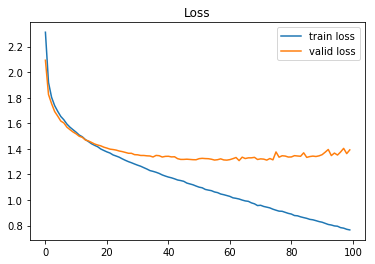

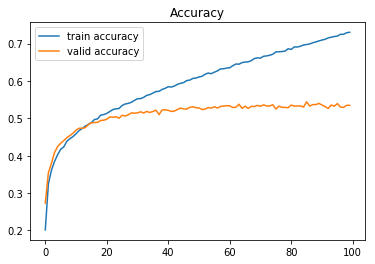

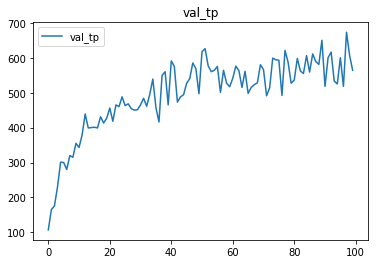

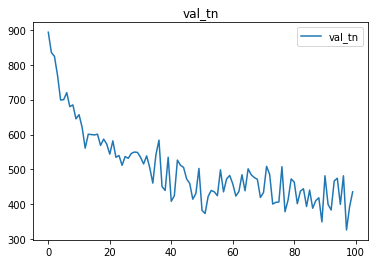

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="val_tp")
plt.legend()
plt.title("val_tp")
plt.show()

plt.plot(range(len(valid_tn)), valid_tn, label="val_tn")
plt.legend()
plt.title("val_tn")
plt.show()